# Données spatiales: découverte de geopandas

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmanipulation%2003_geopandas_tutorial%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=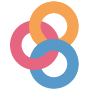" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

Dans ce tutoriel, nous allons utiliser les données suivantes :

-   [Localisations des stations velib](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr) ;
-   [fonds de carte `AdminExpress`](https://geoservices.ign.fr/adminexpress) à
    travers un package `Python` nommé [`cartiflette`](https://github.com/InseeFrLab/cartogether)
    facilitant la récupération de cette source.

La représentation des données, notamment la cartographie, est présentée plus
amplement dans la partie [visualiser](#visualiser). Quelques méthodes
pour faire rapidement des cartes seront présentées ici, mais
l’objet de ce chapitre porte davantage sur la manipulation des données géographiques.

Ce tutoriel s’inspire beaucoup d’un autre tutoriel que j’ai fait pour
`R` disponible
[dans la documentation `utilitr`](https://www.book.utilitr.org/spatdata.html).
Il peut servir de pendant à celui-ci pour l’utilisateur de `R`.

Quelques installations préalables sont nécessaires :

``` python
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
```

Pour être en mesure d’exécuter ce tutoriel, les imports suivants
seront utiles.

In [2]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Données spatiales: quelle différence avec des données traditionnelles ?

**Le terme “données spatiales” désigne les données qui portent sur les caractéristiques géographiques des objets (localisation, contours, liens)**.
Les caractéristiques géographiques des objets sont décrites à l’aide d’un **système de coordonnées**
qui permettent une représentation dans un espace euclidien ($(x,y)$).
Le passage de l’espace réel (la Terre, qui est une sphère) à l’espace plan
se fait grâce à un **système de projection**. Voici quelques exemples
de données spatiales :

-   Une table décrivant des bâtiments, avec les coordonnées géographiques de chaque bâtiment;
-   Le découpage communal du territoire, avec le contour du territoire de chaque commune;
-   Les routes terrestres, avec les coordonnées décrivant leur parcours.

Les données spatiales rassemblent classiquement deux types de données :

1.  des **données géographiques** (ou géométries): objets géométriques tels que des points, des vecteurs, des polygones, ou des maillages (*raster*). Exemple: la forme de chaque chaque commune, les coordonnées d’un bâtiment;
2.  des **données attributaires** (ou attributs): des mesures et des caractéristiques associés aux objets géométriques. Exemple: la population de chaque commune, le nombre de fenêtres et le nombre d’étages d’un bâtiment.

**Les données spatiales sont fréquemment traitées à l’aide d’un système d’information géographique (SIG)**, c’est-à-dire un système d’information capable de stocker, d’organiser et de présenter des données alphanumériques spatialement référencées par des coordonnées dans un système de référence (CRS). `Python` dispose de fonctionnalités lui permettant de réaliser les mêmes tâches qu’un SIG (traitement de données spatiales, représentations cartographiques).

**Les systèmes de projection font l’objet de standards internationaux et sont souvent désignés par des codes dits codes EPSG**. Ce [site](https://epsg.io/) est un bon aide-mémoire. Les plus fréquents, pour les utilisateurs français, sont les suivants (plus d’infos [ici](https://geodesie.ign.fr/contenu/fichiers/documentation/SRCfrance.pdf)):

-   `2154`: système de projection Lambert 93. Il s’agit du système de projection officiel. La plupart des données diffusées par l’administration pour la métropole sont disponibles dans ce système de projection.
-   `27572`: Lambert II étendu. Il s’agit de l’ancien système de projection officiel. Les données spatiales anciennes peuvent être dans ce format.
-   `4326`: WGS 84 ou système de pseudo-Mercator. Attention, ce n’est en réalité pas un système de projection mais un système de coordonnées (longitude / latitude) qui permet simplement un repérage angulaire sur l’ellipsoïde. Il est utilisé pour les données GPS.

## De `pandas` à `geopandas`

Le *package* `geopandas` est une boîte à outils conçue pour faciliter la manipulation de données spatiales. **La grande force de `geopandas` est qu’il permet de manipuler des données spatiales comme s’il s’agissait de données traditionnelles**, car il repose sur le standard ISO 19125 [*simple feature access*](https://en.wikipedia.org/wiki/Simple_Features) défini conjointement par l’*Open Geospatial Consortium (OGC)* et l’*International Organization for Standardization (ISO)*.

Par rapport à un DataFrame standard, un objet `geopandas` comporte
une colonne supplémentaire: `geometry`. Elle stocke les coordonnées des
objets géographiques (ou ensemble de coordonnées s’agissant de contours). Un objet `geopandas` hérite des propriétés d’un
DataFrame pandas mais propose des méthodes adaptées au traitement des données spatiales.

Ainsi, grâce à `geopandas`, on pourra effectuer des manipulations sur les attributs des données comme avec `pandas` mais on pourra également faire des manipulations sur la dimension spatiale des données. En particulier,

-   Calculer des distances et des surfaces;
-   Agréger rapidement des zonages (regrouper les communes en département par exemple);
-   Trouver dans quelle commune se trouve un bâtiment à partir de ses coordonnées géographiques;
-   Recalculer des coordonnées dans un autre système de projection.
-   Faire une carte, rapidement et simplement

<div class="alert alert-warning" role="alert">

Les manipulations de données sur un objet geopandas sont nettement plus lentes que sur un DataFrame traditionnel (car python doit gérer les informations géographiques pendant la manipulation des données). Lorsque vous manipulez des données de grandes dimensions, il peut être préférable d’effectuer les opérations sur les données avant de joindre une géométrie à celles-ci.

</div>

Par rapport à un logiciel spécialisé comme `QGIS`, `python` permettra
d’automatiser le traitement et la représentation des données. D’ailleurs,
`QGIS` utilise lui-même `python`…

# Importer des données spatiales

Les données spatiales sont plus riches que les données traditionnelles car elles
incluent, habituellement, des éléments supplémentaires pour placer dans
un espace cartésien les objets. Cette dimension supplémentaire peut être simple
(un point comporte deux informations supplémentaire: $x$ et $y$) ou
assez complexe (polygones, lignes avec direction, etc.)

Les formats les plus communs de données spatiales sont les suivants :

-   *shapefile* (`.shp`): format (**propriétaire**) le plus commun de données géographiques.
    La table de données (attributs) est stockée dans un fichier séparé des
    données spatiales. En faisant `geopandas.read_file("monfichier.shp")`, le
    package fait lui-même le lien entre les observations et leur représentation spatiale ;
-   *geopackage* (`.gpkg`) : ce (relativement) nouveau format **libre** en un seul fichier également (lui recommandé par l’OGC) vise progressivement à se substituer au shapefile. Il est par exemple le format par défaut dans QGIS.
-   *geojson* (`.json`) : ce format, non préconisé par l’OGC est largement utilisé pour le développement web
    comme dans la librairie `leaflet.js`.
    La dimension spatiale est stockée dans le même fichier que les attributs.
    Ces fichiers sont généralement beaucoup plus légers que les *shapefiles* mais possèdent des limites s’agissant de gros jeux de données.

Cette [page](https://si.ecrins-parcnational.com/blog/2020-02-geojson-shapefile-geopackage.html) compare plus en détail ces trois types de formats de données géographiques.

L’aide de [geopandas](https://geopandas.org/io.html) propose des bouts de code en fonction des différentes situations dans lesquelles on se trouve.

## Exemple: récupérer les découpages territoriaux

L’un des fonds de carte les plus fréquents qu’on utilise est celui des
limites administratives des communes.
Celui-ci peut être récupéré de plusieurs manières.
En premier lieu, pour récupérer
le fond de carte officiel, produit par l’IGN, sous
le nom d’[`AdminExpress`](https://geoservices.ign.fr/adminexpress#telechargementCog)<a name="cite_ref-1"></a>[<sup>\[1\]</sup>](#cite_note-1),
il est possible de se rendre sur le site de l’IGN et de le télécharger depuis
le serveur `FTP`.
Il est également possible d’utiliser l’une des [API de l’IGN](https://api.gouv.fr/les-api/api_carto_cadastre)
mais ces dernières ne sont pas encore très documentées pour des utilisateurs
de `Python`.
Le package `pynsee` propose notamment un module dédié à la récupération de fonds de carte officiels pour valoriser des données
d’open data. L’API sur laquelle il repose étant parfois lente, nous présentons le code dédié uniquement en annexe.

Il existe également une version moins officielle sur [data.gouv](https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/), construite à
partir d’`OpenStreetMap`.

Nous proposons ici une méthode nouvelle de récupération de
ces données qui s’appuie sur le projet interministériel
[`cartiflette`](https://10pourcent.etalab.studio/projets/insee/).  
Ce projet vise à faciliter la récupération des sources officielles, notamment
celles de l’IGN, et leur association à des jeux de données géographiques.

Pour l’installer, il est nécessaire d’utiliser les commandes suivantes
depuis un `Jupyter Notebook` (si vous utilisez la ligne de commande directement,
vous pouvez retirer les `!` et `%` en début de ligne):

In [3]:
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

Ici, nous sommes intéressés par les contours des communes
de la petite couronne. On pourrait désirer récupérer
l’ensemble de la région Ile-de-France mais nous
allons nous contenter de l’analyse de Paris intra-muros
et des départements limitrophes.
Les contours de cet espace peuvent être récupérés de la manière suivante:

In [4]:
import cartiflette.s3

shp_communes = cartiflette.s3.download_vectorfile_url_all(
    values = ["75", "92", "93", "94"],
    level="COMMUNE",
    vectorfile_format="geojson",
    decoupage="departement",
    year=2022)

shp_communes.head()

ID 
 NOM 
 NOM_M 
 INSEE_COM 
 STATUT 
 POPULATION 
 INSEE_CAN 
 INSEE_ARR 
 INSEE_DEP 
 INSEE_REG 
 SIREN_EPCI 
 geometry 
 
 
 
 
 0 
 COMMUNE_0000000009736048 
 Paris 
 PARIS 
 75056 
 Capitale d'état 
 2165423 
 NR 
 1 
 75 
 11 
 200054781 
 POLYGON ((653313.800 6857558.100, 653249.300 6... 
 
 
 0 
 COMMUNE_0000000009736037 
 Levallois-Perret 
 LEVALLOIS-PERRET 
 92044 
 Commune simple 
 66082 
 16 
 2 
 92 
 11 
 200054781/200057982 
 POLYGON ((647761.400 6867306.900, 647839.200 6... 
 
 
 1 
 COMMUNE_0000000009736055 
 Bois-Colombes 
 BOIS-COLOMBES 
 92009 
 Commune simple 
 28841 
 11 
 2 
 92 
 11 
 200054781/200057990 
 POLYGON ((646224.700 6867615.800, 646229.000 6... 
 
 
 2 
 COMMUNE_0000000009736538 
 Malakoff 
 MALAKOFF 
 92046 
 Commune simple 
 30950 
 18 
 1 
 92 
 11 
 200054781/200057966 
 POLYGON ((646995.300 6857373.400, 647177.500 6... 
 
 
 3 
 COMMUNE_0000000009736038 
 Clichy 
 CLICHY 
 92024 
 Commune simple 
 63089 
 09 
 2 
 92 
 11 
 200054781/200057990 
 POLYGON ((648952.800 6866241.200, 648865.900 6...

On reconnaît la structure d’un `DataFrame` `Pandas`. A cette structure s’ajoute
une colonne `geometry` qui enregistre la position des limites des polygones de chaque
observation.

Comme vu précédemment, le système de projection est un élément important. Il permet à `Python`
d’interpréter les valeurs des points (deux dimensions) en position sur
la terre, qui n’est pas un espace plan.

In [5]:
shp_communes.crs

<Derived Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Ici, les données sont dans le système de projection Lambert-93
qui est le système légal de projection pour la France
métropolitaine.

Pour s’assurer qu’on a bien récupéré les contours voulus,
on peut représenter graphiquement
les contours grâce à la méthode `plot` sur laquelle nous
reviendrons :

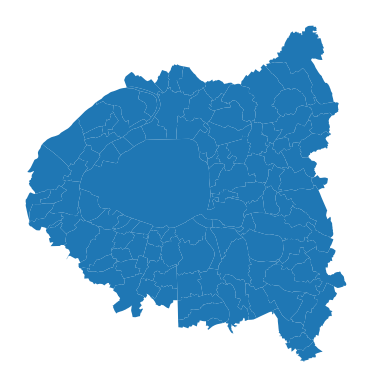

In [6]:
ax = shp_communes.plot()
ax.set_axis_off()

On peut remarquer que la ville de Paris ne comporte pas d’arrondissements
sur cette carte. Pour vous en convaincre, vous pouvez exécuter la
commande :

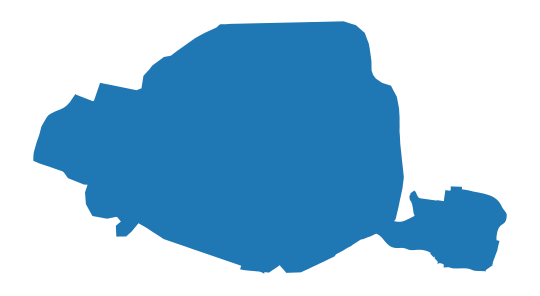

In [7]:
ax = shp_communes.loc[shp_communes['INSEE_DEP']=="75"].plot()
ax.set_axis_off()

Il faut donc utiliser une source complémentaire.
Le contour officiel des arrondissements est
produit par l’IGN séparemment des contours de communes.
Les contours d’arrondissements sont également
disponibles
grâce à `cartiflette`:

In [8]:
arrondissements = cartiflette.s3.download_vectorfile_url_all(
    values = "75",
    level="ARRONDISSEMENT_MUNICIPAL",
    vectorfile_format="geojson",
    decoupage="departement",
    year=2022)

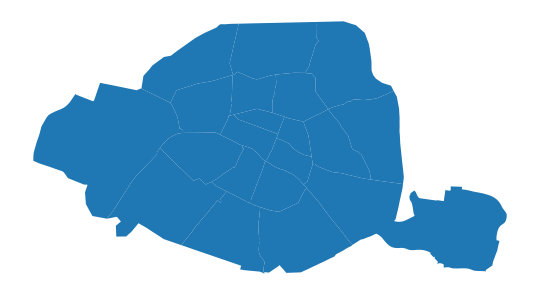

In [9]:
ax = arrondissements.plot()
ax.set_axis_off()

Il ne reste plus qu’à remplacer Paris par
ses arrondissements dans `shp_communes`.
Pour cela, on peut utiliser les méthodes
vues dans le chapitre `Pandas` relatives
aux filtres et à la concaténation
de plusieurs `DataFrames`:

In [10]:
import pandas as pd

shp_communes = pd.concat(
  [
    shp_communes[shp_communes['INSEE_DEP'] != "75"],
    arrondissements
  ])

Nous allons refaire la carte précédente de la petite couronne.
Au passage, nous allons ajouter un fond de carte contextuel grâce
au package `contextily`. Nous verrons, par la suite,
qu’il est nécessaire de reprojeter les données dans un
système de projection particulier (code EPSG: `3857`) pour
ce type de représentation :

<AxesSubplot: >

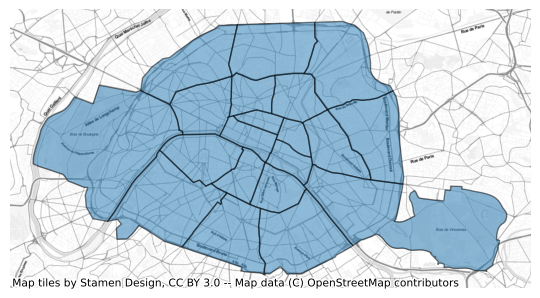

In [11]:
paris = shp_communes.loc[shp_communes['INSEE_DEP'] == "75"].to_crs(3857)
ax = paris.plot(alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
ax

# Opérations sur les attributs et les géométries

## Import des données velib

Souvent, le découpage communal ne sert qu’en fond de cartes, pour donner des
repères. En complément de celui-ci, on peut désirer exploiter
un autre jeu de données. On va partir des données de localisation des
stations velib,
disponibles [sur le site d’open data de la ville de Paris](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/table/) et
requêtables directement par l’url
<https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr>

In [12]:
velib_data = 'https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr'
stations = gpd.read_file(velib_data)
stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Les données sont dans le système de projection WGS84 qui est celui du
système GPS. Celui-ci s’intègre bien avec les fonds de carte
`Stamen`, `OpenStreetMap` ou `Google Maps`. En toute rigueur, si on
désire effectuer certains calculs géométriques (mesurer des surfaces…), il est
nécessaire de re-projeter les données dans un système qui préserve la géométrie
(c’est le cas du Lambert 93).

Pour avoir une intuition de la localisation des stations, et notamment de la
densité hétérogène de celles-ci,
on peut afficher les données sur la carte des communes
de la petite couronne. Il s’agit donc d’enrichir la carte
précédente d’une couche supplémentaire, à savoir la localisation
des stations. Au passage, on va utiliser un fond de carte
plus esthétique:

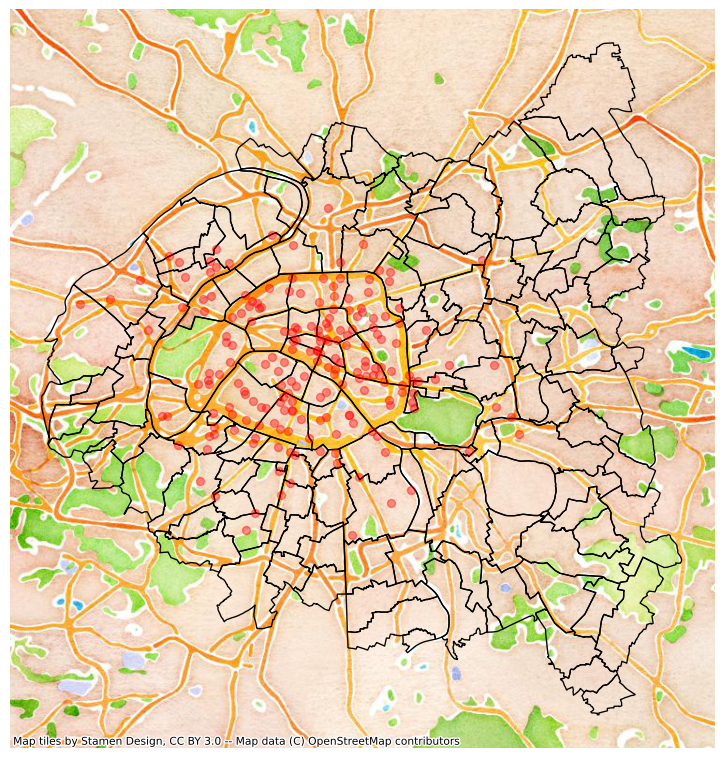

In [13]:
fig,ax = plt.subplots(figsize=(10, 10))
stations.sample(200).to_crs(3857).plot(ax = ax, color = 'red', alpha = 0.4, zorder=2)
shp_communes.to_crs(3857).plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, source = ctx.providers.Stamen.Watercolor)
ax.set_axis_off()

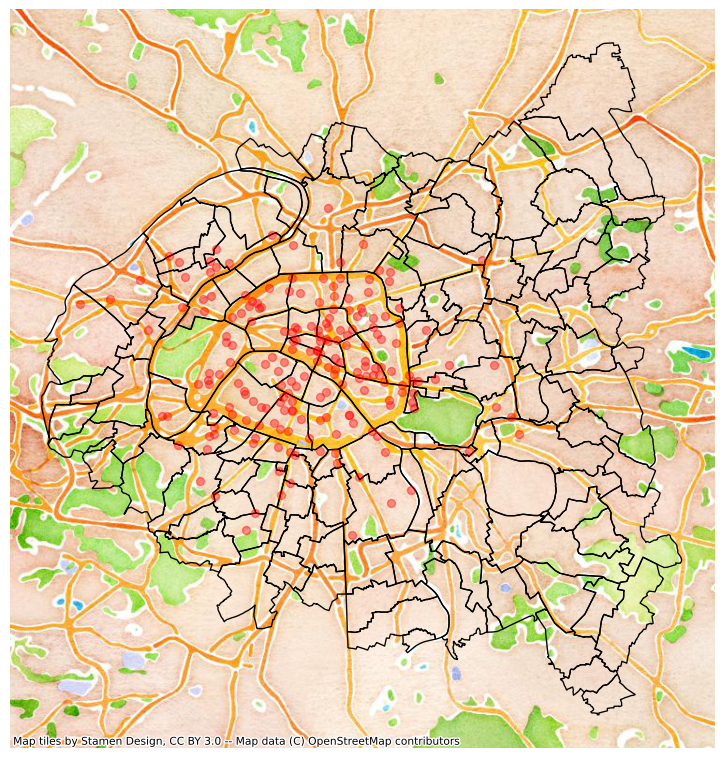

In [15]:
fig = ax.get_figure()
fig.savefig("featured.png")

Découvrez ci-dessous par étape les différentes lignes de commandes permettant d’afficher cette carte complète,
étape par étape :

:one:
Afficher le nuage de points de 200 stations vélibs prises au hasard

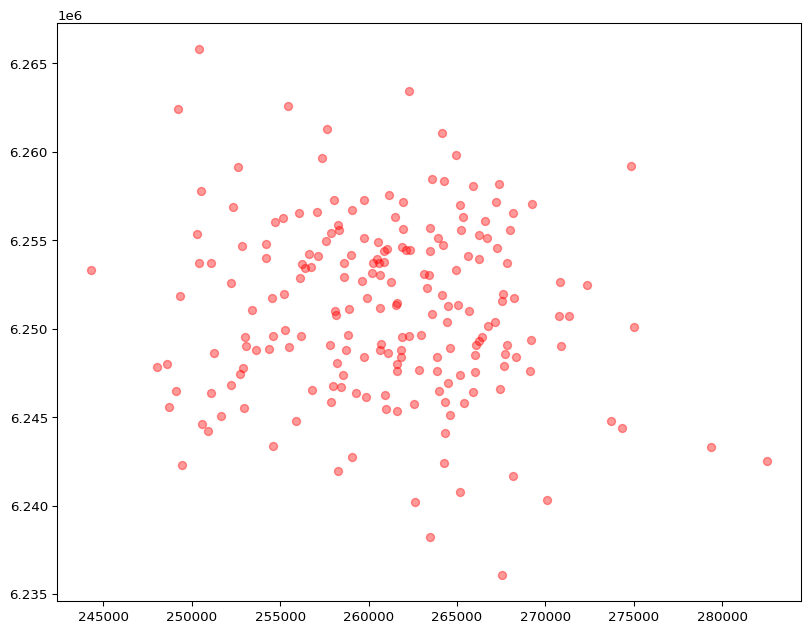

:two:
Ajouter à cette couche, en-dessous, les contours des communes

:three:
Ajouter un fond de carte de type *open street map* grâce au package
`contextily`

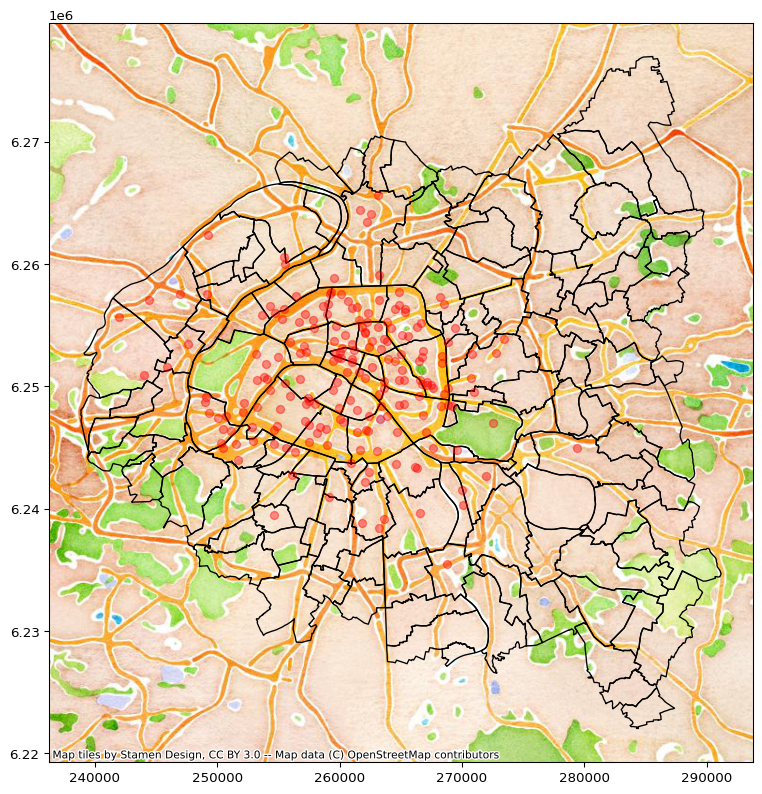

:four:
Il ne reste plus qu’à retirer l’axe des coordonnées, qui n’est pas très
esthétique.

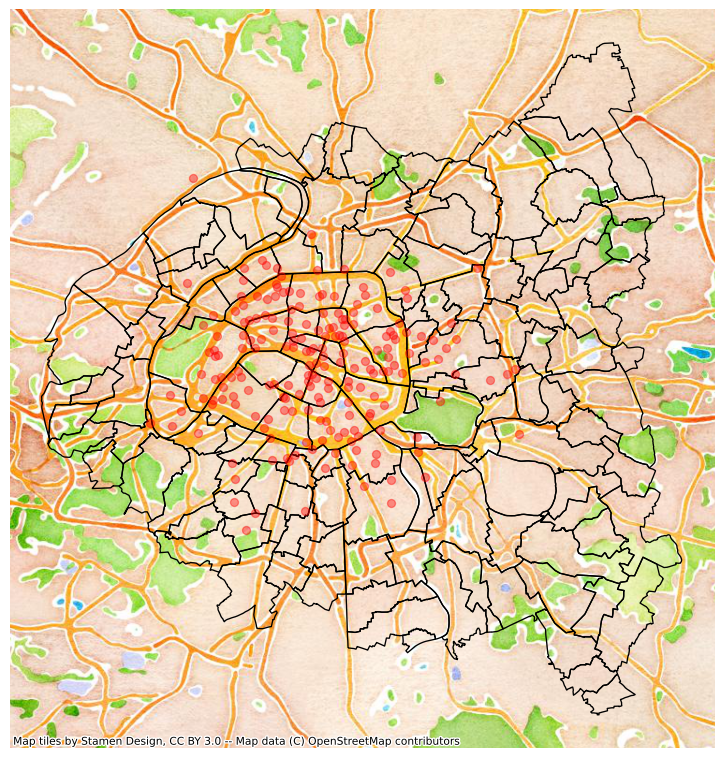

*In fine*, on obtient la carte désirée.

## Opérations sur les attributs

Toutes les opérations possibles sur un objet `Pandas` le sont également
sur un objet `GeoPandas`. Pour manipuler les données, et non la géométrie,
on parlera d’opérations sur les attributs.

Par exemple, si on désire
connaître quelques statistiques sur la taille des stations:

In [24]:
stations.describe()

capacity 
 
 
 
 
 count 
 1441.000000 
 
 
 mean 
 31.264400 
 
 
 std 
 11.950194 
 
 
 min 
 0.000000 
 
 
 25% 
 23.000000 
 
 
 50% 
 29.000000 
 
 
 75% 
 37.000000 
 
 
 max 
 74.000000

Pour connaître les plus grands départements de France métropolitaine,
procédons en deux étapes:

1.  Récupérons le contour des communes de France métropolitaine dans son ensemble
    grâce à `cartiflette`.
    Notons qu’on pourrait récupérer directement les contours départementaux mais
    pour l’exercice, nous allons le créer nous-mêmes comme agrégation
    des contours communaux.
2.  Calculons la surface (méthode `area` sur un objet `GeoPandas.GeoDataFrame` ramenée en km², attention néamoins au système de projection comme cela est expliqué plus bas)

In [25]:
from cartiflette.download import get_vectorfile_ign
france = get_vectorfile_ign(level = "COMMUNE", field = "metropole")

Downloading:   0%|          | 0.00/244M [00:00<?, ?iB/s]

Downloading:   0%|          | 32.0k/244M [00:00<16:18, 261kiB/s]

Downloading:   0%|          | 80.0k/244M [00:00<12:53, 330kiB/s]

Downloading:   0%|          | 113k/244M [00:00<14:19, 297kiB/s] 

Downloading:   0%|          | 208k/244M [00:00<08:57, 475kiB/s]

Downloading:   0%|          | 431k/244M [00:00<04:32, 936kiB/s]

Downloading:   0%|          | 893k/244M [00:00<02:17, 1.85MiB/s]

Downloading:   1%|          | 1.78M/244M [00:00<01:09, 3.64MiB/s]

Downloading:   1%|          | 2.67M/244M [00:01<00:59, 4.25MiB/s]

Downloading:   1%|▏         | 3.28M/244M [00:01<01:03, 3.97MiB/s]

Downloading:   2%|▏         | 4.05M/244M [00:01<00:53, 4.70MiB/s]

Downloading:   2%|▏         | 4.91M/244M [00:01<00:43, 5.72MiB/s]

Downloading:   2%|▏         | 6.08M/244M [00:01<00:33, 7.36MiB/s]

Downloading:   3%|▎         | 6.85M/244M [00:01<00:42, 5.88MiB/s]

Downloading:   3%|▎         | 8.05M/244M [00:02<00:43, 5.64MiB/s]

Downloading:   4%|▍         | 9.64M/244M [00:02<00:42, 5.78MiB/s]

Downloading:   5%|▍         | 11.5M/244M [00:02<00:30, 8.01MiB/s]

Downloading:   5%|▌         | 12.4M/244M [00:02<00:34, 6.96MiB/s]

Downloading:   5%|▌         | 13.2M/244M [00:02<00:36, 6.56MiB/s]

Downloading:   6%|▌         | 14.0M/244M [00:03<00:44, 5.43MiB/s]

Downloading:   6%|▋         | 15.4M/244M [00:03<00:55, 4.34MiB/s]

Downloading:   7%|▋         | 16.4M/244M [00:03<00:51, 4.65MiB/s]

Downloading:   7%|▋         | 17.7M/244M [00:04<00:59, 3.95MiB/s]

Downloading:   8%|▊         | 18.7M/244M [00:04<00:52, 4.52MiB/s]

Downloading:   8%|▊         | 20.7M/244M [00:04<00:35, 6.66MiB/s]

Downloading:   9%|▉         | 21.5M/244M [00:04<00:55, 4.22MiB/s]

Downloading:   9%|▉         | 22.2M/244M [00:04<00:52, 4.40MiB/s]

Downloading:  10%|▉         | 23.9M/244M [00:05<00:37, 6.21MiB/s]

Downloading:  10%|█         | 25.2M/244M [00:05<00:46, 4.90MiB/s]

Downloading:  11%|█         | 26.2M/244M [00:05<00:42, 5.39MiB/s]

Downloading:  11%|█         | 27.3M/244M [00:16<10:54, 347kiB/s] 

Downloading:  11%|█         | 27.3M/244M [00:16<11:01, 343kiB/s]

Downloading:  11%|█▏        | 27.8M/244M [00:17<09:30, 397kiB/s]

Downloading:  12%|█▏        | 28.2M/244M [00:17<07:54, 476kiB/s]

Downloading:  12%|█▏        | 29.2M/244M [00:17<04:59, 752kiB/s]

Downloading:  13%|█▎        | 31.0M/244M [00:17<02:28, 1.50MiB/s]

Downloading:  13%|█▎        | 32.4M/244M [00:18<01:41, 2.18MiB/s]

Downloading:  14%|█▍        | 34.7M/244M [00:18<01:00, 3.65MiB/s]

Downloading:  15%|█▍        | 36.1M/244M [00:18<00:47, 4.57MiB/s]

Downloading:  15%|█▌        | 37.6M/244M [00:18<00:38, 5.58MiB/s]

Downloading:  16%|█▌        | 38.7M/244M [00:18<00:35, 6.00MiB/s]

Downloading:  16%|█▋        | 39.7M/244M [00:18<00:32, 6.50MiB/s]

Downloading:  17%|█▋        | 40.9M/244M [00:18<00:32, 6.58MiB/s]

Downloading:  17%|█▋        | 41.8M/244M [00:19<00:40, 5.26MiB/s]

Downloading:  17%|█▋        | 42.5M/244M [00:19<00:46, 4.56MiB/s]

Downloading:  18%|█▊        | 43.1M/244M [00:19<00:52, 4.02MiB/s]

Downloading:  18%|█▊        | 43.6M/244M [00:19<00:52, 3.97MiB/s]

Downloading:  18%|█▊        | 44.0M/244M [00:20<01:06, 3.17MiB/s]

Downloading:  18%|█▊        | 44.7M/244M [00:20<00:56, 3.71MiB/s]

Downloading:  19%|█▊        | 45.2M/244M [00:20<00:51, 4.02MiB/s]

Downloading:  19%|█▊        | 45.7M/244M [00:20<01:19, 2.61MiB/s]

Downloading:  19%|█▉        | 46.1M/244M [00:20<01:12, 2.85MiB/s]

Downloading:  19%|█▉        | 47.4M/244M [00:20<00:44, 4.64MiB/s]

Downloading:  20%|█▉        | 48.0M/244M [00:20<00:43, 4.76MiB/s]

Downloading:  20%|█▉        | 48.6M/244M [00:21<00:41, 4.96MiB/s]

Downloading:  20%|██        | 49.1M/244M [00:21<00:39, 5.15MiB/s]

Downloading:  20%|██        | 49.7M/244M [00:21<00:40, 5.05MiB/s]

Downloading:  21%|██        | 50.2M/244M [00:21<00:46, 4.38MiB/s]

Downloading:  21%|██        | 50.9M/244M [00:21<00:57, 3.51MiB/s]

Downloading:  21%|██▏       | 52.0M/244M [00:21<00:40, 4.94MiB/s]

Downloading:  22%|██▏       | 52.6M/244M [00:21<00:39, 5.05MiB/s]

Downloading:  22%|██▏       | 53.2M/244M [00:22<00:39, 5.12MiB/s]

Downloading:  22%|██▏       | 53.7M/244M [00:22<00:45, 4.36MiB/s]

Downloading:  22%|██▏       | 54.5M/244M [00:22<00:54, 3.62MiB/s]

Downloading:  23%|██▎       | 55.8M/244M [00:22<00:36, 5.36MiB/s]

Downloading:  23%|██▎       | 56.4M/244M [00:22<00:36, 5.37MiB/s]

Downloading:  23%|██▎       | 57.0M/244M [00:22<00:35, 5.47MiB/s]

Downloading:  24%|██▎       | 57.6M/244M [00:23<00:34, 5.63MiB/s]

Downloading:  24%|██▍       | 58.2M/244M [00:23<00:34, 5.56MiB/s]

Downloading:  24%|██▍       | 58.8M/244M [00:23<00:34, 5.62MiB/s]

Downloading:  24%|██▍       | 59.4M/244M [00:23<00:34, 5.66MiB/s]

Downloading:  25%|██▍       | 60.0M/244M [00:23<00:33, 5.77MiB/s]

Downloading:  25%|██▍       | 60.5M/244M [00:23<00:33, 5.75MiB/s]

Downloading:  25%|██▌       | 61.1M/244M [00:23<00:32, 5.97MiB/s]

Downloading:  25%|██▌       | 61.8M/244M [00:23<00:31, 5.98MiB/s]

Downloading:  26%|██▌       | 62.4M/244M [00:23<00:31, 6.05MiB/s]

Downloading:  26%|██▌       | 63.0M/244M [00:24<01:00, 3.14MiB/s]

Downloading:  26%|██▌       | 63.4M/244M [00:24<00:57, 3.27MiB/s]

Downloading:  27%|██▋       | 64.7M/244M [00:24<00:37, 4.97MiB/s]

Downloading:  27%|██▋       | 65.4M/244M [00:24<00:34, 5.44MiB/s]

Downloading:  27%|██▋       | 66.0M/244M [00:24<00:33, 5.51MiB/s]

Downloading:  27%|██▋       | 66.7M/244M [00:24<00:32, 5.71MiB/s]

Downloading:  28%|██▊       | 67.4M/244M [00:24<00:29, 6.21MiB/s]

Downloading:  28%|██▊       | 68.1M/244M [00:25<00:28, 6.54MiB/s]

Downloading:  28%|██▊       | 68.9M/244M [00:25<00:26, 6.89MiB/s]

Downloading:  29%|██▊       | 69.6M/244M [00:25<00:27, 6.60MiB/s]

Downloading:  29%|██▉       | 70.3M/244M [00:25<00:27, 6.54MiB/s]

Downloading:  29%|██▉       | 71.0M/244M [00:25<00:26, 6.82MiB/s]

Downloading:  29%|██▉       | 71.8M/244M [00:25<00:24, 7.28MiB/s]

Downloading:  30%|██▉       | 72.5M/244M [00:25<00:24, 7.19MiB/s]

Downloading:  30%|███       | 73.2M/244M [00:25<00:25, 7.15MiB/s]

Downloading:  30%|███       | 73.9M/244M [00:25<00:25, 6.89MiB/s]

Downloading:  31%|███       | 74.6M/244M [00:26<00:27, 6.36MiB/s]

Downloading:  31%|███       | 75.2M/244M [00:26<00:28, 6.11MiB/s]

Downloading:  31%|███       | 75.8M/244M [00:26<00:29, 5.91MiB/s]

Downloading:  31%|███▏      | 76.4M/244M [00:27<01:19, 2.20MiB/s]

Downloading:  32%|███▏      | 76.9M/244M [00:27<01:08, 2.56MiB/s]

Downloading:  32%|███▏      | 77.4M/244M [00:27<00:58, 3.00MiB/s]

Downloading:  32%|███▏      | 78.0M/244M [00:27<00:50, 3.45MiB/s]

Downloading:  32%|███▏      | 78.5M/244M [00:27<00:46, 3.76MiB/s]

Downloading:  32%|███▏      | 78.9M/244M [00:27<00:44, 3.92MiB/s]

Downloading:  33%|███▎      | 79.4M/244M [00:27<00:58, 2.97MiB/s]

Downloading:  33%|███▎      | 80.8M/244M [00:27<00:33, 5.07MiB/s]

Downloading:  33%|███▎      | 81.4M/244M [00:28<00:32, 5.30MiB/s]

Downloading:  34%|███▎      | 82.0M/244M [00:28<00:31, 5.34MiB/s]

Downloading:  34%|███▍      | 82.6M/244M [00:28<00:32, 5.18MiB/s]

Downloading:  34%|███▍      | 83.1M/244M [00:28<00:31, 5.31MiB/s]

Downloading:  34%|███▍      | 83.7M/244M [00:28<00:30, 5.44MiB/s]

Downloading:  35%|███▍      | 84.3M/244M [00:28<00:29, 5.67MiB/s]

Downloading:  35%|███▍      | 85.0M/244M [00:28<00:26, 6.19MiB/s]

Downloading:  35%|███▌      | 85.8M/244M [00:28<00:25, 6.60MiB/s]

Downloading:  35%|███▌      | 86.5M/244M [00:29<00:33, 4.90MiB/s]

Downloading:  36%|███▌      | 87.4M/244M [00:29<00:28, 5.67MiB/s]

Downloading:  36%|███▌      | 88.3M/244M [00:29<00:26, 6.07MiB/s]

Downloading:  36%|███▋      | 88.9M/244M [00:29<00:26, 6.07MiB/s]

Downloading:  37%|███▋      | 89.5M/244M [00:29<00:26, 6.00MiB/s]

Downloading:  37%|███▋      | 90.1M/244M [00:29<00:29, 5.55MiB/s]

Downloading:  37%|███▋      | 90.9M/244M [00:29<00:28, 5.71MiB/s]

Downloading:  38%|███▊      | 91.6M/244M [00:29<00:27, 5.79MiB/s]

Downloading:  38%|███▊      | 92.4M/244M [00:30<00:30, 5.28MiB/s]

Downloading:  38%|███▊      | 92.9M/244M [00:30<00:35, 4.51MiB/s]

Downloading:  38%|███▊      | 93.8M/244M [00:30<00:29, 5.33MiB/s]

Downloading:  39%|███▊      | 94.4M/244M [00:30<00:35, 4.40MiB/s]

Downloading:  39%|███▉      | 95.1M/244M [00:30<00:31, 4.87MiB/s]

Downloading:  39%|███▉      | 96.1M/244M [00:30<00:26, 5.79MiB/s]

Downloading:  40%|███▉      | 96.7M/244M [00:31<00:34, 4.47MiB/s]

Downloading:  40%|███▉      | 97.5M/244M [00:31<00:32, 4.72MiB/s]

Downloading:  40%|████      | 98.5M/244M [00:31<00:27, 5.63MiB/s]

Downloading:  41%|████      | 99.5M/244M [00:31<00:35, 4.22MiB/s]

Downloading:  41%|████      | 100M/244M [00:31<00:29, 5.06MiB/s] 

Downloading:  42%|████▏     | 102M/244M [00:31<00:25, 5.94MiB/s]

Downloading:  42%|████▏     | 102M/244M [00:32<00:25, 5.78MiB/s]

Downloading:  42%|████▏     | 103M/244M [00:32<00:25, 5.88MiB/s]

Downloading:  43%|████▎     | 104M/244M [00:32<00:21, 6.77MiB/s]

Downloading:  43%|████▎     | 105M/244M [00:32<00:19, 7.47MiB/s]

Downloading:  44%|████▎     | 106M/244M [00:32<00:17, 8.24MiB/s]

Downloading:  44%|████▍     | 107M/244M [00:32<00:18, 7.61MiB/s]

Downloading:  44%|████▍     | 108M/244M [00:32<00:18, 7.52MiB/s]

Downloading:  45%|████▍     | 109M/244M [00:32<00:19, 7.12MiB/s]

Downloading:  45%|████▍     | 109M/244M [00:33<00:21, 6.69MiB/s]

Downloading:  45%|████▌     | 110M/244M [00:33<00:21, 6.42MiB/s]

Downloading:  45%|████▌     | 111M/244M [00:33<00:22, 6.31MiB/s]

Downloading:  46%|████▌     | 111M/244M [00:33<00:22, 6.31MiB/s]

Downloading:  46%|████▌     | 112M/244M [00:33<00:22, 6.16MiB/s]

Downloading:  46%|████▌     | 112M/244M [00:33<00:22, 6.16MiB/s]

Downloading:  46%|████▋     | 113M/244M [00:33<00:25, 5.44MiB/s]

Downloading:  47%|████▋     | 114M/244M [00:34<00:39, 3.42MiB/s]

Downloading:  47%|████▋     | 114M/244M [00:34<00:37, 3.63MiB/s]

Downloading:  47%|████▋     | 115M/244M [00:34<00:28, 4.70MiB/s]

Downloading:  48%|████▊     | 116M/244M [00:34<00:23, 5.64MiB/s]

Downloading:  48%|████▊     | 117M/244M [00:34<00:31, 4.22MiB/s]

Downloading:  48%|████▊     | 118M/244M [00:34<00:28, 4.71MiB/s]

Downloading:  49%|████▊     | 119M/244M [00:35<00:23, 5.62MiB/s]

Downloading:  49%|████▉     | 119M/244M [00:42<06:10, 352kiB/s] 

Downloading:  49%|████▉     | 120M/244M [00:42<05:05, 425kiB/s]

Downloading:  49%|████▉     | 120M/244M [00:42<04:11, 515kiB/s]

Downloading:  50%|████▉     | 121M/244M [00:42<03:04, 697kiB/s]

Downloading:  50%|████▉     | 122M/244M [00:43<01:51, 1.15MiB/s]

Downloading:  50%|█████     | 123M/244M [00:43<01:13, 1.72MiB/s]

Downloading:  51%|█████     | 124M/244M [00:43<00:52, 2.39MiB/s]

Downloading:  51%|█████▏    | 125M/244M [00:43<00:39, 3.18MiB/s]

Downloading:  52%|█████▏    | 126M/244M [00:43<00:30, 4.03MiB/s]

Downloading:  52%|█████▏    | 127M/244M [00:43<00:24, 4.89MiB/s]

Downloading:  53%|█████▎    | 128M/244M [00:43<00:21, 5.73MiB/s]

Downloading:  53%|█████▎    | 129M/244M [00:43<00:18, 6.50MiB/s]

Downloading:  54%|█████▎    | 131M/244M [00:44<00:16, 7.15MiB/s]

Downloading:  54%|█████▍    | 132M/244M [00:44<00:15, 7.73MiB/s]

Downloading:  55%|█████▍    | 133M/244M [00:44<00:14, 8.24MiB/s]

Downloading:  55%|█████▌    | 134M/244M [00:44<00:13, 8.64MiB/s]

Downloading:  56%|█████▌    | 135M/244M [00:44<00:12, 9.00MiB/s]

Downloading:  56%|█████▌    | 137M/244M [00:44<00:12, 9.26MiB/s]

Downloading:  57%|█████▋    | 138M/244M [00:44<00:11, 9.44MiB/s]

Downloading:  57%|█████▋    | 139M/244M [00:44<00:11, 9.59MiB/s]

Downloading:  58%|█████▊    | 140M/244M [00:45<00:11, 9.73MiB/s]

Downloading:  58%|█████▊    | 142M/244M [00:45<00:10, 9.79MiB/s]

Downloading:  58%|█████▊    | 143M/244M [00:45<00:12, 8.22MiB/s]

Downloading:  59%|█████▉    | 143M/244M [00:45<00:14, 7.29MiB/s]

Downloading:  59%|█████▉    | 144M/244M [00:45<00:15, 6.64MiB/s]

Downloading:  59%|█████▉    | 145M/244M [00:45<00:16, 6.26MiB/s]

Downloading:  60%|█████▉    | 145M/244M [00:45<00:17, 5.77MiB/s]

Downloading:  60%|█████▉    | 146M/244M [00:46<00:18, 5.41MiB/s]

Downloading:  60%|██████    | 146M/244M [00:46<00:19, 5.16MiB/s]

Downloading:  60%|██████    | 147M/244M [00:46<00:19, 5.15MiB/s]

Downloading:  60%|██████    | 147M/244M [00:46<00:22, 4.45MiB/s]

Downloading:  61%|██████    | 148M/244M [00:46<00:22, 4.45MiB/s]

Downloading:  61%|██████    | 148M/244M [00:46<00:25, 3.94MiB/s]

Downloading:  61%|██████    | 149M/244M [00:46<00:23, 4.18MiB/s]

Downloading:  61%|██████    | 149M/244M [00:46<00:25, 3.84MiB/s]

Downloading:  61%|██████▏   | 150M/244M [00:47<00:21, 4.48MiB/s]

Downloading:  62%|██████▏   | 150M/244M [00:47<00:24, 3.95MiB/s]

Downloading:  62%|██████▏   | 151M/244M [00:53<06:54, 235kiB/s] 

Downloading:  62%|██████▏   | 151M/244M [00:54<05:38, 287kiB/s]

Downloading:  62%|██████▏   | 151M/244M [00:54<04:36, 352kiB/s]

Downloading:  62%|██████▏   | 151M/244M [00:54<03:44, 431kiB/s]

Downloading:  63%|██████▎   | 152M/244M [00:54<01:47, 894kiB/s]

Downloading:  63%|██████▎   | 153M/244M [00:54<01:02, 1.51MiB/s]

Downloading:  63%|██████▎   | 154M/244M [00:54<00:41, 2.25MiB/s]

Downloading:  64%|██████▍   | 156M/244M [00:54<00:29, 3.09MiB/s]

Downloading:  64%|██████▍   | 157M/244M [00:54<00:22, 3.98MiB/s]

Downloading:  65%|██████▍   | 158M/244M [00:55<00:18, 4.88MiB/s]

Downloading:  65%|██████▌   | 159M/244M [00:55<00:15, 5.76MiB/s]

Downloading:  66%|██████▌   | 160M/244M [00:55<00:13, 6.63MiB/s]

Downloading:  66%|██████▌   | 161M/244M [00:55<00:11, 7.35MiB/s]

Downloading:  67%|██████▋   | 162M/244M [00:55<00:10, 7.93MiB/s]

Downloading:  67%|██████▋   | 164M/244M [00:55<00:09, 8.44MiB/s]

Downloading:  68%|██████▊   | 165M/244M [00:55<00:09, 8.92MiB/s]

Downloading:  68%|██████▊   | 166M/244M [00:56<00:08, 9.35MiB/s]

Downloading:  69%|██████▊   | 167M/244M [00:56<00:09, 8.27MiB/s]

Downloading:  69%|██████▉   | 168M/244M [00:56<00:09, 7.94MiB/s]

Downloading:  69%|██████▉   | 169M/244M [00:56<00:09, 8.54MiB/s]

Downloading:  70%|██████▉   | 170M/244M [00:56<00:09, 8.17MiB/s]

Downloading:  70%|███████   | 171M/244M [00:56<00:09, 7.99MiB/s]

Downloading:  71%|███████   | 172M/244M [00:56<00:09, 7.89MiB/s]

Downloading:  71%|███████   | 173M/244M [00:56<00:09, 7.82MiB/s]

Downloading:  71%|███████▏  | 174M/244M [00:57<00:09, 7.85MiB/s]

Downloading:  72%|███████▏  | 175M/244M [00:57<00:09, 7.91MiB/s]

Downloading:  72%|███████▏  | 176M/244M [00:57<00:09, 7.89MiB/s]

Downloading:  73%|███████▎  | 177M/244M [00:57<00:08, 8.50MiB/s]

Downloading:  73%|███████▎  | 178M/244M [00:57<00:08, 8.60MiB/s]

Downloading:  73%|███████▎  | 179M/244M [00:57<00:08, 8.00MiB/s]

Downloading:  74%|███████▎  | 179M/244M [00:57<00:09, 6.94MiB/s]

Downloading:  74%|███████▍  | 180M/244M [00:58<00:14, 4.51MiB/s]

Downloading:  74%|███████▍  | 181M/244M [00:58<00:13, 4.78MiB/s]

Downloading:  74%|███████▍  | 182M/244M [00:58<00:12, 5.34MiB/s]

Downloading:  75%|███████▍  | 182M/244M [00:59<00:34, 1.87MiB/s]

Downloading:  75%|███████▍  | 183M/244M [00:59<00:30, 2.07MiB/s]

Downloading:  75%|███████▌  | 183M/244M [00:59<00:22, 2.79MiB/s]

Downloading:  76%|███████▌  | 184M/244M [00:59<00:17, 3.61MiB/s]

Downloading:  76%|███████▌  | 185M/244M [01:04<02:13, 462kiB/s] 

Downloading:  76%|███████▌  | 185M/244M [01:04<01:54, 535kiB/s]

Downloading:  76%|███████▌  | 186M/244M [01:04<01:37, 626kiB/s]

Downloading:  76%|███████▋  | 186M/244M [01:05<01:00, 991kiB/s]

Downloading:  77%|███████▋  | 187M/244M [01:05<00:39, 1.50MiB/s]

Downloading:  77%|███████▋  | 188M/244M [01:05<00:27, 2.15MiB/s]

Downloading:  78%|███████▊  | 189M/244M [01:05<00:19, 2.91MiB/s]

Downloading:  78%|███████▊  | 190M/244M [01:05<00:14, 3.74MiB/s]

Downloading:  79%|███████▊  | 191M/244M [01:05<00:11, 4.64MiB/s]

Downloading:  79%|███████▉  | 192M/244M [01:05<00:11, 4.76MiB/s]

Downloading:  79%|███████▉  | 194M/244M [01:05<00:08, 6.29MiB/s]

Downloading:  80%|███████▉  | 194M/244M [01:06<00:08, 6.32MiB/s]

Downloading:  80%|████████  | 195M/244M [01:06<00:08, 6.32MiB/s]

Downloading:  80%|████████  | 196M/244M [01:06<00:07, 6.34MiB/s]

Downloading:  81%|████████  | 197M/244M [01:06<00:07, 6.43MiB/s]

Downloading:  81%|████████  | 198M/244M [01:06<00:07, 6.48MiB/s]

Downloading:  81%|████████▏ | 198M/244M [01:06<00:07, 6.56MiB/s]

Downloading:  82%|████████▏ | 199M/244M [01:06<00:07, 6.62MiB/s]

Downloading:  82%|████████▏ | 200M/244M [01:07<00:06, 6.66MiB/s]

Downloading:  82%|████████▏ | 201M/244M [01:07<00:06, 6.72MiB/s]

Downloading:  83%|████████▎ | 202M/244M [01:07<00:06, 6.81MiB/s]

Downloading:  83%|████████▎ | 203M/244M [01:07<00:06, 6.83MiB/s]

Downloading:  84%|████████▎ | 204M/244M [01:07<00:06, 6.95MiB/s]

Downloading:  84%|████████▍ | 204M/244M [01:08<00:12, 3.22MiB/s]

Downloading:  84%|████████▍ | 205M/244M [01:08<00:12, 3.36MiB/s]

Downloading:  84%|████████▍ | 205M/244M [01:08<00:11, 3.46MiB/s]

Downloading:  84%|████████▍ | 206M/244M [01:08<00:10, 3.94MiB/s]

Downloading:  85%|████████▍ | 207M/244M [01:08<00:08, 4.57MiB/s]

Downloading:  85%|████████▌ | 208M/244M [01:08<00:07, 5.08MiB/s]

Downloading:  85%|████████▌ | 208M/244M [01:08<00:06, 5.49MiB/s]

Downloading:  86%|████████▌ | 209M/244M [01:09<00:06, 5.82MiB/s]

Downloading:  86%|████████▌ | 210M/244M [01:09<00:05, 6.05MiB/s]

Downloading:  87%|████████▋ | 211M/244M [01:09<00:05, 6.27MiB/s]

Downloading:  87%|████████▋ | 212M/244M [01:12<00:41, 817kiB/s] 

Downloading:  87%|████████▋ | 212M/244M [01:12<00:40, 829kiB/s]

Downloading:  87%|████████▋ | 212M/244M [01:12<00:33, 972kiB/s]

Downloading:  87%|████████▋ | 213M/244M [01:13<00:22, 1.41MiB/s]

Downloading:  88%|████████▊ | 214M/244M [01:13<00:16, 1.92MiB/s]

Downloading:  88%|████████▊ | 215M/244M [01:13<00:12, 2.52MiB/s]

Downloading:  88%|████████▊ | 216M/244M [01:13<00:09, 3.14MiB/s]

Downloading:  89%|████████▉ | 216M/244M [01:13<00:07, 3.76MiB/s]

Downloading:  89%|████████▉ | 217M/244M [01:13<00:06, 4.36MiB/s]

Downloading:  89%|████████▉ | 218M/244M [01:13<00:05, 4.94MiB/s]

Downloading:  90%|████████▉ | 219M/244M [01:13<00:04, 5.45MiB/s]

Downloading:  90%|█████████ | 220M/244M [01:14<00:04, 5.88MiB/s]

Downloading:  91%|█████████ | 221M/244M [01:14<00:03, 6.28MiB/s]

Downloading:  91%|█████████ | 222M/244M [01:14<00:03, 6.59MiB/s]

Downloading:  91%|█████████▏| 223M/244M [01:14<00:03, 6.86MiB/s]

Downloading:  92%|█████████▏| 224M/244M [01:14<00:02, 7.08MiB/s]

Downloading:  92%|█████████▏| 225M/244M [01:14<00:02, 7.17MiB/s]

Downloading:  93%|█████████▎| 225M/244M [01:14<00:02, 7.32MiB/s]

Downloading:  93%|█████████▎| 226M/244M [01:15<00:02, 7.47MiB/s]

Downloading:  93%|█████████▎| 227M/244M [01:15<00:02, 7.56MiB/s]

Downloading:  94%|█████████▎| 228M/244M [01:15<00:02, 7.60MiB/s]

Downloading:  94%|█████████▍| 229M/244M [01:15<00:01, 7.62MiB/s]

Downloading:  94%|█████████▍| 230M/244M [01:15<00:01, 7.66MiB/s]

Downloading:  95%|█████████▍| 231M/244M [01:15<00:01, 7.66MiB/s]

Downloading:  95%|█████████▌| 232M/244M [01:15<00:01, 7.66MiB/s]

Downloading:  96%|█████████▌| 233M/244M [01:15<00:01, 7.70MiB/s]

Downloading:  96%|█████████▌| 234M/244M [01:16<00:01, 7.60MiB/s]

Downloading:  96%|█████████▋| 235M/244M [01:16<00:01, 7.74MiB/s]

Downloading:  97%|█████████▋| 236M/244M [01:16<00:01, 7.72MiB/s]

Downloading:  97%|█████████▋| 237M/244M [01:16<00:00, 7.70MiB/s]

Downloading:  98%|█████████▊| 238M/244M [01:16<00:00, 7.67MiB/s]

Downloading:  98%|█████████▊| 239M/244M [01:16<00:00, 7.71MiB/s]

Downloading:  98%|█████████▊| 240M/244M [01:16<00:00, 7.52MiB/s]

Downloading:  99%|█████████▉| 241M/244M [01:16<00:00, 7.70MiB/s]

Downloading:  99%|█████████▉| 242M/244M [01:17<00:00, 7.81MiB/s]

Downloading: 100%|█████████▉| 243M/244M [01:17<00:00, 8.25MiB/s]

Downloading: 100%|█████████▉| 244M/244M [01:17<00:00, 8.05MiB/s]

Downloading: 100%|██████████| 244M/244M [01:17<00:00, 3.30MiB/s]

In [26]:
france['surface'] = france.area.div(10**6)

Les plus grands départements s’obtiennent par une agrégation des
surfaces communales :

In [27]:
france.groupby('INSEE_DEP').sum().sort_values('surface', ascending = False)

/tmp/ipykernel_382/267603710.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


POPULATION 
 surface 
 
 
 INSEE_DEP 
 
 
 
 
 
 
 33 
 1623749 
 10367.786664 
 
 
 40 
 413690 
 9354.208426 
 
 
 24 
 413223 
 9210.826232 
 
 
 21 
 534124 
 8787.757953 
 
 
 12 
 279595 
 8770.152839 
 
 
 ... 
 ... 
 ... 
 
 
 90 
 141318 
 610.126210 
 
 
 94 
 1407124 
 244.811547 
 
 
 93 
 1644903 
 236.867946 
 
 
 92 
 1624357 
 175.570732 
 
 
 75 
 2165423 
 105.431453 
 
 
 
 96 rows × 2 columns

Si on veut directement les plus
grandes communes de France métropolitaine :

In [28]:
france.sort_values('surface', ascending = False).head(10)

ID 
 NOM 
 NOM_M 
 INSEE_COM 
 STATUT 
 POPULATION 
 INSEE_CAN 
 INSEE_ARR 
 INSEE_DEP 
 INSEE_REG 
 SIREN_EPCI 
 geometry 
 surface 
 
 
 
 
 240 
 COMMUNE_0000000009760125 
 Arles 
 ARLES 
 13004 
 Sous-préfecture 
 50454 
 04 
 2 
 13 
 93 
 241300417 
 POLYGON ((841785.400 6290116.800, 841787.600 6... 
 757.418542 
 
 
 308 
 COMMUNE_0000000009753237 
 Val-Cenis 
 VAL-CENIS 
 73290 
 Commune simple 
 2062 
 10 
 3 
 73 
 84 
 200070340 
 POLYGON ((1017798.400 6466625.200, 1017573.700... 
 455.423629 
 
 
 19074 
 COMMUNE_0000000009760352 
 Saintes-Maries-de-la-Mer 
 SAINTES-MARIES-DE-LA-MER 
 13096 
 Commune simple 
 2144 
 04 
 2 
 13 
 93 
 241300417 
 MULTIPOLYGON (((813751.200 6261910.500, 813716... 
 371.214527 
 
 
 274 
 COMMUNE_0000000009746086 
 Chemillé-en-Anjou 
 CHEMILLE-EN-ANJOU 
 49092 
 Commune simple 
 20828 
 11 
 2 
 49 
 52 
 200060010 
 POLYGON ((429946.200 6682848.700, 429939.900 6... 
 320.816158 
 
 
 436 
 COMMUNE_0000000009744893 
 Noyant-Villages 
 NOYANT-VILLAGES 
 49228 
 Commune simple 
 5546 
 08 
 3 
 49 
 52 
 244900882 
 POLYGON ((490764.000 6714964.800, 490615.800 6... 
 300.457150 
 
 
 14079 
 COMMUNE_0000000009744622 
 Baugé-en-Anjou 
 BAUGE-EN-ANJOU 
 49018 
 Commune simple 
 11829 
 08 
 3 
 49 
 52 
 244900882 
 POLYGON ((456856.800 6728449.000, 456857.600 6... 
 270.223011 
 
 
 1279 
 COMMUNE_0000000009762779 
 Laruns 
 LARUNS 
 64320 
 Commune simple 
 1185 
 15 
 2 
 64 
 75 
 246400337 
 POLYGON ((428969.700 6200124.400, 428966.500 6... 
 248.657511 
 
 
 275 
 COMMUNE_0000000009750652 
 Chamonix-Mont-Blanc 
 CHAMONIX-MONT-BLANC 
 74056 
 Commune simple 
 8640 
 10 
 2 
 74 
 84 
 200023372 
 POLYGON ((1000337.100 6532738.100, 1000258.500... 
 245.012587 
 
 
 6206 
 COMMUNE_0000000009743670 
 Segré-en-Anjou Bleu 
 SEGRE-EN-ANJOU BLEU 
 49331 
 Sous-préfecture 
 17462 
 20 
 4 
 49 
 52 
 244900809 
 MULTIPOLYGON (((421207.400 6742529.000, 421215... 
 243.945747 
 
 
 473 
 COMMUNE_0000000009761156 
 Marseille 
 MARSEILLE 
 13055 
 Préfecture de région 
 870731 
 98 
 3 
 13 
 93 
 200054807 
 MULTIPOLYGON (((894824.800 6233030.600, 894821... 
 238.445688

Lors des étapes d’agrégation, `groupby` ne conserve pas les géométries. Autrement
dit, si on effectue, par exemple, une somme en fonction d’une variable de groupe avec
le combo `groupby(...).sum(...)` , on perd
la dimension géographique.

Il est néanmoins possible d’aggréger à la fois les géométries et les
attribus avec la méthode `dissolve`:

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/geopandas/geodataframe.py:1705: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


<AxesSubplot: >

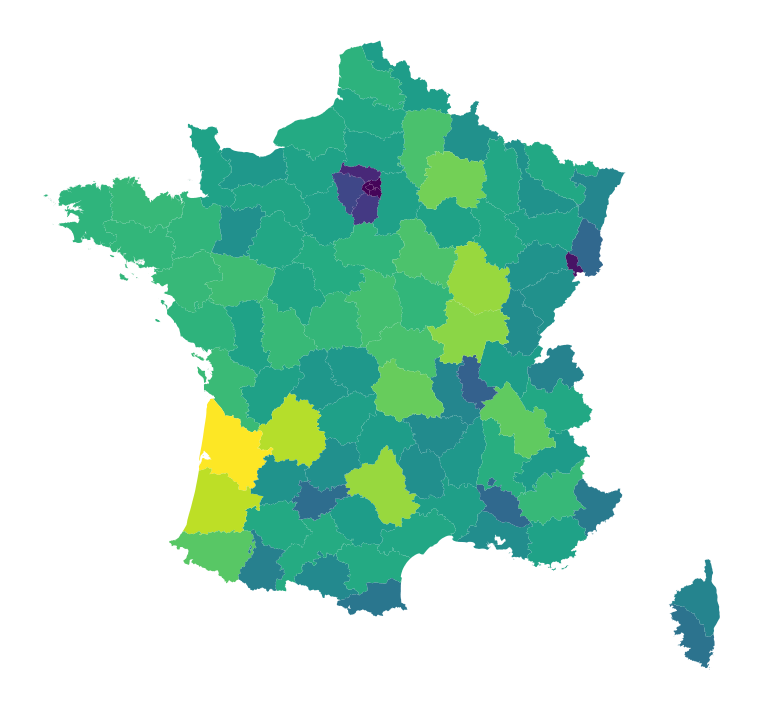

In [29]:
fig,ax = plt.subplots(figsize=(10, 10))
france.dissolve(by='INSEE_DEP', aggfunc='sum').plot(ax = ax, column = "surface")
ax.set_axis_off()
ax

Pour produire cette carte, il serait néanmoins plus simple de directement
récupérer les fonds officiels des départements plutôt que d’agréger les
contours des communes:

Data have been previously downloaded and are still available in /tmp/EXPRESS-COG-2022

<AxesSubplot: >

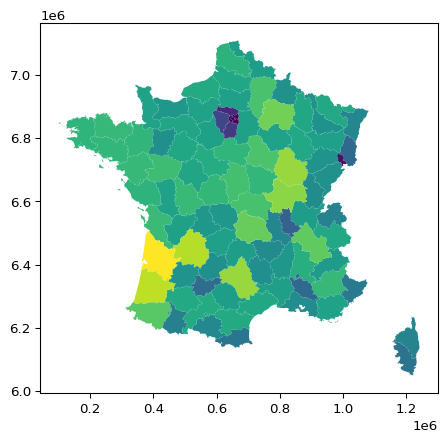

In [30]:
dep = get_vectorfile_ign(level = "DEPARTEMENT", field = "metropole")
dep["area"] = dep.area
dep.plot(column = "area")

## Opérations sur les géométries

<div class="alert alert-danger" role="alert">

Les données sont en système de coordonnées WGS 84 ou pseudo-Mercator (epsg: `4326`) et ne sont pas projetées. C’est un format approprié lorsqu’il s’agit d’utiliser un fonds
de carte `OpenStreetMap`, `Stamen`, `Google Maps`, etc.

Mais ce n’est pas un
format sur lequel on désire faire des calculs car les distances sont faussées sans utiliser de projection. D’ailleurs, `geopandas` refusera certaines opérations
sur des données dont le crs est `4326`. On reprojete ainsi les données
dans la projection officielle pour la métropole, le Lambert 93
(epsg: `2154`).

</div>

In [31]:
communes = shp_communes.to_crs(2154)
stations = stations.to_crs(2154)

Outre la représentation graphique simplifiée,
sur laquelle nous reviendrons ultérieurement, l’intérêt principal d’utiliser
`GeoPandas` est l’existence de méthodes efficaces pour
manipuler la dimension spatiale. Un certain nombre proviennent du
package
[`Shapely`](https://shapely.readthedocs.io/en/latest/manual.html#general-attributes-and-methods).

Par exemple, on peut recalculer la taille d’une commune ou d’arrondissement
avec la méthode `area` (et diviser par $10^6$ pour avoir des $km^2$ au lieu
des $m^2$):

In [32]:
communes['superficie'] = communes.area.div(10**6)
communes

ID 
 NOM 
 NOM_M 
 INSEE_COM 
 STATUT 
 POPULATION 
 INSEE_CAN 
 INSEE_ARR 
 INSEE_DEP 
 INSEE_REG 
 SIREN_EPCI 
 geometry 
 INSEE_ARM 
 superficie 
 
 
 
 
 0 
 COMMUNE_0000000009736037 
 Levallois-Perret 
 LEVALLOIS-PERRET 
 92044 
 Commune simple 
 66082 
 16 
 2 
 92 
 11 
 200054781/200057982 
 POLYGON ((647761.400 6867306.900, 647839.200 6... 
 NaN 
 2.417473 
 
 
 1 
 COMMUNE_0000000009736055 
 Bois-Colombes 
 BOIS-COLOMBES 
 92009 
 Commune simple 
 28841 
 11 
 2 
 92 
 11 
 200054781/200057990 
 POLYGON ((646224.700 6867615.800, 646229.000 6... 
 NaN 
 1.926596 
 
 
 2 
 COMMUNE_0000000009736538 
 Malakoff 
 MALAKOFF 
 92046 
 Commune simple 
 30950 
 18 
 1 
 92 
 11 
 200054781/200057966 
 POLYGON ((646995.300 6857373.400, 647177.500 6... 
 NaN 
 2.070926 
 
 
 3 
 COMMUNE_0000000009736038 
 Clichy 
 CLICHY 
 92024 
 Commune simple 
 63089 
 09 
 2 
 92 
 11 
 200054781/200057990 
 POLYGON ((648952.800 6866241.200, 648865.900 6... 
 NaN 
 3.081760 
 
 
 4 
 COMMUNE_0000000009736052 
 Nanterre 
 NANTERRE 
 92050 
 Préfecture 
 96277 
 99 
 2 
 92 
 11 
 200054781/200057982 
 POLYGON ((643490.700 6867612.300, 643581.500 6... 
 NaN 
 12.231387 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 15 
 ARR_MUNI0000000009736040 
 Paris 18e Arrondissement 
 PARIS 18E ARRONDISSEMENT 
 75056 
 NaN 
 192468 
 NaN 
 NaN 
 75 
 NaN 
 NaN 
 POLYGON ((653494.000 6867048.500, 653534.900 6... 
 75118 
 5.995535 
 
 
 16 
 ARR_MUNI0000000009736034 
 Paris 19e Arrondissement 
 PARIS 19E ARRONDISSEMENT 
 75056 
 NaN 
 184573 
 NaN 
 NaN 
 75 
 NaN 
 NaN 
 POLYGON ((654295.200 6863738.400, 654184.000 6... 
 75119 
 6.784887 
 
 
 17 
 ARR_MUNI0000000009736542 
 Paris 7e Arrondissement 
 PARIS 7E ARRONDISSEMENT 
 75056 
 NaN 
 48888 
 NaN 
 NaN 
 75 
 NaN 
 NaN 
 POLYGON ((649855.900 6860974.600, 649831.400 6... 
 75107 
 4.087759 
 
 
 18 
 ARR_MUNI0000000009736540 
 Paris 15e Arrondissement 
 PARIS 15E ARRONDISSEMENT 
 75056 
 NaN 
 230981 
 NaN 
 NaN 
 75 
 NaN 
 NaN 
 POLYGON ((647833.600 6858932.000, 647635.500 6... 
 75115 
 8.472095 
 
 
 19 
 ARR_MUNI0000000009736532 
 Paris 12e Arrondissement 
 PARIS 12E ARRONDISSEMENT 
 75056 
 NaN 
 139297 
 NaN 
 NaN 
 75 
 NaN 
 NaN 
 POLYGON ((660776.100 6858595.600, 660774.700 6... 
 75112 
 16.380874 
 
 
 
 143 rows × 14 columns

Une méthode qu’on utilise régulièrement est `centroid` qui, comme son nom l’indique,
recherche le centroïde de chaque polygone et transforme ainsi des données
surfaciques en données ponctuelles. Par exemple, pour
représenter approximativement les centres des villages de la
Haute-Garonne (31), on
fera

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning:

The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).


<AxesSubplot: >

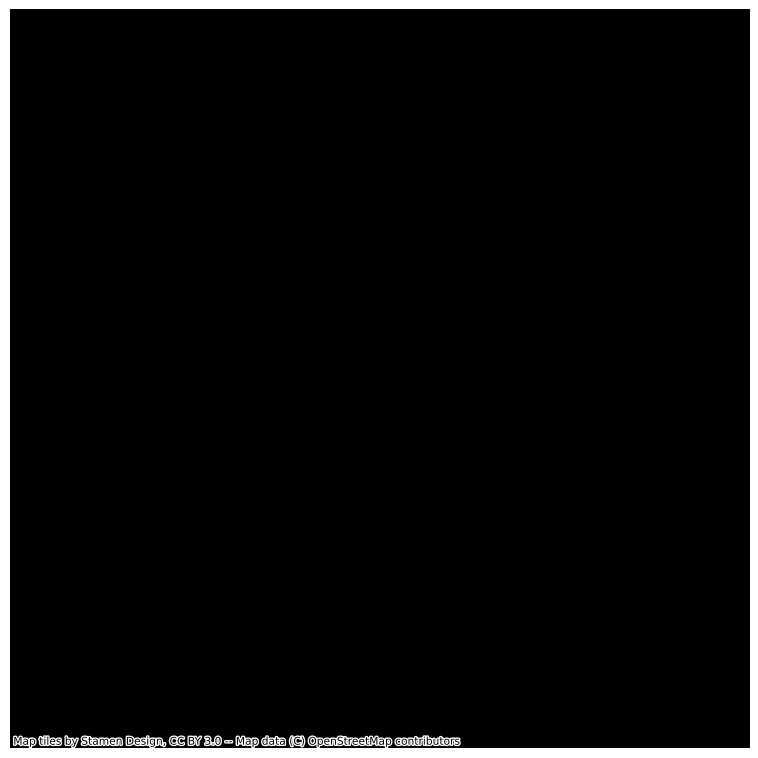

In [33]:
departement = communes[communes['INSEE_DEP'] == "31"].copy()
departement['geometry'] = departement['geometry'].centroid


ax = departement.plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
communes[communes['INSEE_DEP'] == "31"].plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, crs = stations.crs.to_string(), source = ctx.providers.Stamen.Toner)
ax.set_axis_off()
ax

<Figure size 672x480 with 0 Axes>

# Gérer le système de projection

Précédemment, nous avons appliqué une méthode `to_crs` pour reprojeter
les données dans un système de projection différent de celui du fichier
d’origine :

In [35]:
communes = communes.to_crs(2154)
stations = stations.to_crs(2154)

Le système de projection est fondamental pour que la dimension
spatiale soit bien interprétée par `Python`. Un mauvais système de représentation
fausse l’appréciation visuelle mais peut aussi entraîner des erreurs dans
les calculs sur la dimension spatiale.
Ce [post](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/geographic-vs-projected-coordinate-reference-systems-UTM/) propose de riches éléments sur le
sujet, notamment l’image suivante qui montre bien le principe d’une projection :

![Les différents types de projection](https://www.earthdatascience.org/images/courses/earth-analytics/spatial-data/spatial-projection-transformations-crs.png)

La Terre peut ainsi être représentée de multiples manières, ce qui n’est pas neutre sur la manière de se représenter
certains continents.
L’Afrique apparaît beaucoup moins vaste qu’elle ne l’est en réalité sur les cartes utilisant
cette projection.
L’une des déformations les mieux connue est celle provoquée par la projection Mercator.
Le Groënland paraît avoir
la même surface que l’Amérique du Sud. Pourtant, cette dernière est 8 fois
plus grande.

Il existe en fait de nombreuses représentations possibles du monde, plus ou moins
alambiquées. Les projections sont très nombreuses et certaines peuvent avoir une [forme suprenante](https://imgs.xkcd.com/comics/map_projections.png).
Par exemple,
la [projection de Spillhaus](https://storymaps.arcgis.com/stories/756bcae18d304a1eac140f19f4d5cb3d)
propose de centrer la vue sur les océans et non une terre. C’est pour
cette raison qu’on parle parfois de monde tel que vu par les poissons
à son propos.

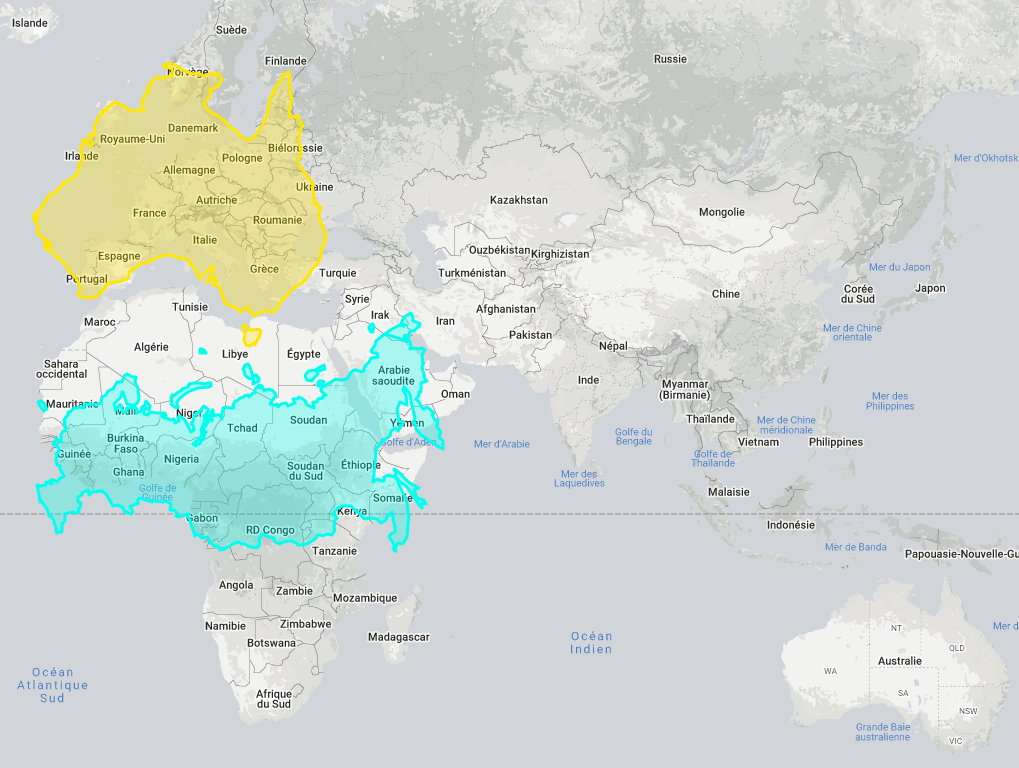
*Exemple de reprojection de pays depuis le site [thetruesize.com](https://thetruesize.com/)*

Concernant la gestion des projections avec `GeoPandas`,
la [documentation officielle](https://geopandas.org/projections.html) est très bien
faite. Elle fournit notamment l’avertissement suivant qu’il est
bon d’avoir en tête:

> Be aware that most of the time you don’t have to set a projection. Data loaded from a reputable source (using the geopandas.read_file() command) should always include projection information. You can see an objects current CRS through the GeoSeries.crs attribute.
>
> From time to time, however, you may get data that does not include a projection. In this situation, you have to set the CRS so geopandas knows how to interpret the coordinates.

![](https://imgs.xkcd.com/comics/bad_map_projection_south_america.png)
*Image empruntée à XKCD <https://xkcd.com/2256/> qu’on peut également trouver sur <https://blog.chrislansdown.com/2020/01/17/a-great-map-projection-joke/>*

Pour déterminer le système de projection d’une base de données, on peut vérifier l’attribut `crs`:

In [36]:
communes.crs

<Derived Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica.
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Les deux principales méthodes pour définir le système de projection utilisé sont:

-   **`df.set_crs`**: cette commande sert à préciser quel est le système de projection utilisé, c’est-à-dire comment les coordonnées *(x,y)* sont reliées à la surface terrestre. **Cette commande ne doit pas être utilisée pour transformer le système de coordonnées, seulement pour le définir**.
-   **`df.to_crs`**: **cette commande sert à projeter les points d’une géométrie dans une autre, c’est-à-dire à recalculer les coordonnées selon un autre système de projection.**

Dans le cas particulier de production de carte avec un fond `OpenStreetMaps` ou une carte dynamique `leaflet`, il est nécessaire de dé-projeter les données (par exemple à partir du Lambert-93) pour atterrir dans le système non-projeté WGS 84 (code EPSG 4326). Ce site [dédié aux projections géographiques](https://epsg.io/) peut-être utile pour retrouver le système de projection d’un fichier où il n’est pas indiqué.

La définition du système de projection se fait de la manière suivante (:warning: avant de le faire, se souvenir de l’avertissement !):

``` python
communes = communes.set_crs(2154)
```

Alors que la reprojection (projection Albers : `5070`) s’obtient de la manière suivante :

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/geopandas/geodataframe.py:1705: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


<AxesSubplot: >

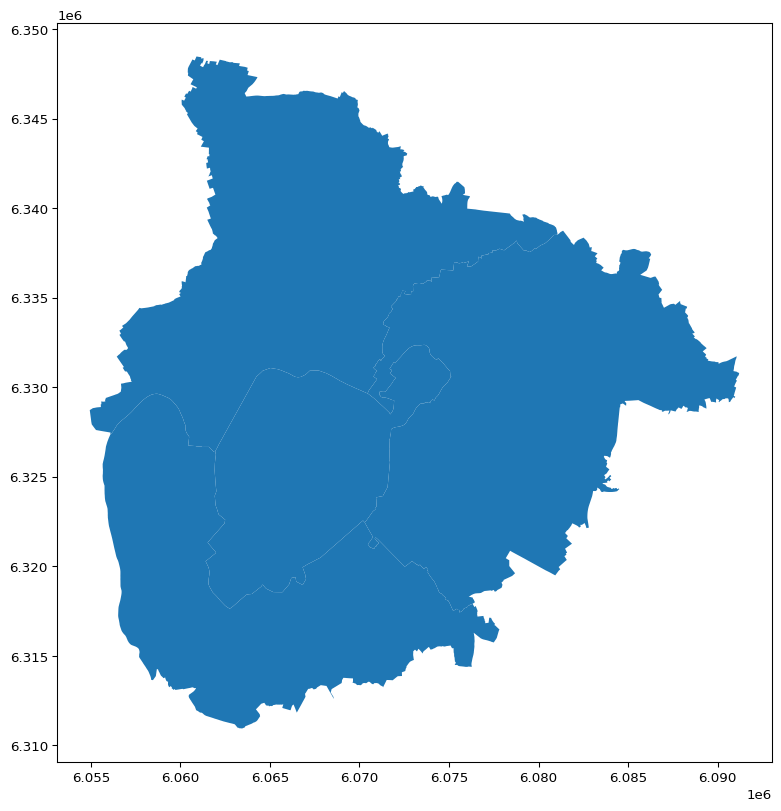

In [37]:
fig,ax = plt.subplots(figsize=(10, 10))
communes[communes['INSEE_DEP'] != "97"].dissolve(by='INSEE_DEP', aggfunc='sum').to_crs(5070).plot(ax = ax)
ax

<Figure size 672x480 with 0 Axes>

On le voit, cela modifie totalement la représentation de l’objet dans l’espace.
Clairement, cette projection n’est pas adaptée aux longitudes et latitudes françaises.
C’est normal, il s’agit d’une projection adaptée au continent
nord-américain (et encore, pas dans son ensemble !).

<AxesSubplot: >

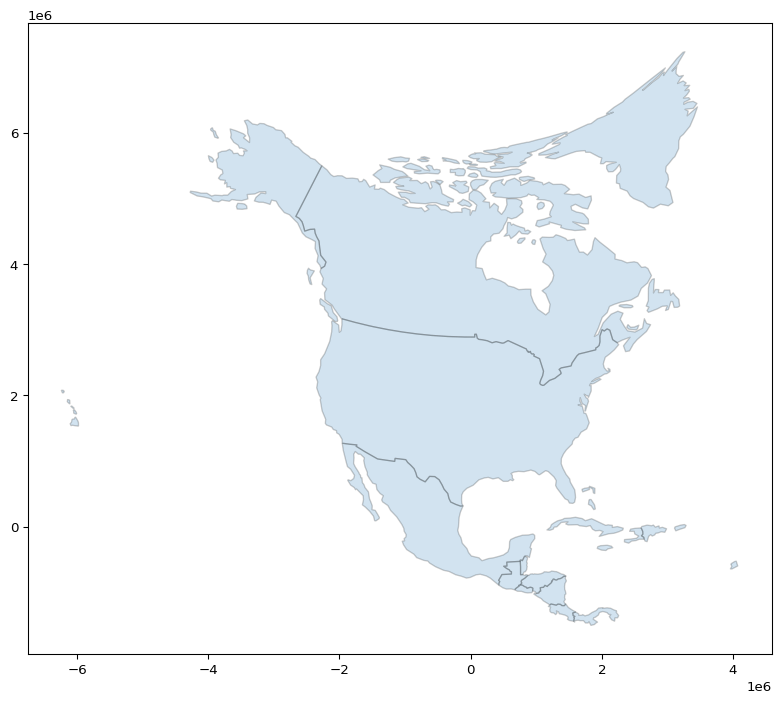

In [39]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig,ax = plt.subplots(figsize=(10, 10))
world[world.continent == "North America"].to_crs(5070).plot(alpha = 0.2, edgecolor = "k", ax = ax)
ax

<Figure size 672x480 with 0 Axes>

# Joindre des données

## Joindre des données sur des attributs

Ce type de jointure se fait entre un objet géographique et un
deuxième objet, géographique ou non. A l’exception de la question
des géométries, il n’y a pas de différence par rapport à `Pandas`.

La seule différence avec `Pandas` est dans la dimension géographique.
Si on désire conserver la dimension géographique, il faut faire
attention à faire :

``` python
geopandas_object.merge(pandas_object)
```

Si on utilise deux objets géographiques mais ne désire conserver qu’une seule
dimension géographique<a name="cite_ref-2"></a>[<sup>\[2\]</sup>](#cite_note-2), on fera

``` python
geopandas_object1.merge(geopandas_object2)
```

Seule la géométrie de l’objet de gauche
sera conservée, même si on fait un *right join*.

Il est techniquement possible d’avoir un `DataFrame` comportant plusieurs
géographies. Par exemple une géométrie polygone et une géométrie point
(le centroid). C’est néanmoins souvent compliqué à gérer et donc peu
recommandable.

## Prolongation possible : joindre des données sur dimension géographique

Le chapitre suivant permettra de mettre en oeuvre des
jointures géographiques.

<div class="alert alert-warning" role="alert">

Les jointures spatiales peuvent être très gourmandes en ressources (car il peut être nécessaire de croiser toutes les géométries de `x` avec toutes les géométries de `y`). Voici deux conseils qui peuvent vous aider :

-   Il est préférable de tester les jointures géographiques sur un petit échantillon de données, pour estimer le temps et les ressources nécessaires à la réalisation de la jointure.
-   Il est parfois possible d’écrire une fonction qui réduit la taille du problème. Exemple: vous voulez déterminer dans quelle commune se situe un logement dont vous connaissez les coordonnées et le département; vous pouvez écrire une fonction qui réalise pour chaque département une jointure spatiale entre les logements situés dans ce département et les communes de ce département, puis empiler les 101 tables de sorties.

</div>

# Annexe

## Récupération des données depuis data.gouv

Avec cette méthode, les données des limites administratives demandent donc un peu de travail pour être
importées car elles sont zippées (mais c’est un bon exercice !).

Le code suivant, dont les
détails apparaîtront plus clairs après la lecture de la partie
*[webscraping](webscraping)* permet de :

1.  Télécharger les données avec `requests` dans un dossier temporaire
2.  Les dézipper avec le module `zipfile`

La fonction suivante automatise un peu le processus :

In [41]:
import requests
import tempfile
import zipfile

url = 'https://www.data.gouv.fr/fr/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165'
temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open("{}/{}.zip".format(dirname, destname), 'wb').write(myfile.content)
  with zipfile.ZipFile("{}/{}.zip".format(dirname, destname), 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

In [42]:
download_unzip(url)

In [43]:
shp_communes = gpd.read_file(temporary_location + "/borders/communes-20220101.shp")

Ici, les données ne sont pas projetées puisqu’elles sont dans le
système WSG84 (epsg: 4326) ce qui permet de facilement ajouter
un fonds de carte `Openstreetmap` ou `Stamen` pour rendre une représentation
graphique plus esthétique.
En toute rigueur, pour faire une carte statique d’un pays en particulier,
il faudrait reprojeter les données dans un système de projection adapté à la zone géographique étudiée
(par exemple le Lambert-93 pour la France métropolitaine).

On peut ainsi représenter Paris pour se donner une idée de la nature
du shapefile utilisé :

In [44]:
paris = shp_communes.loc[shp_communes['insee'].str.startswith("75")]

fig,ax = plt.subplots(figsize=(10, 10))
paris.plot(ax = ax, alpha=0.5, edgecolor='blue')
ctx.add_basemap(ax, crs = paris.crs.to_string())
ax.set_axis_off()
ax

On voit ainsi que les données pour Paris ne comportent pas d’arrondissement,
ce qui est limitant pour une analyse focalisée sur Paris. On va donc les
récupérer sur le site d’open data de la ville de Paris et les substituer
à Paris :

In [45]:
arrondissements = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
arrondissements = arrondissements.rename(columns = {"c_arinsee": "insee"})
arrondissements['insee'] = arrondissements['insee'].astype(str)
shp_communes = shp_communes[~shp_communes.insee.str.startswith("75")].append(arrondissements)

Pour produire la carte, il faudrait faire:

In [46]:
paris = shp_communes.loc[shp_communes.insee.str.startswith("75")]

fig,ax = plt.subplots(figsize=(10, 10))

paris.plot(ax = ax, alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs = paris.crs.to_string())
ax.set_axis_off()
ax

## Récupération des données depuis le package `pynsee`

Pour connaître les contraintes d’installation du package `pynsee`,
se référer à la partie de cours dédiée à `Pandas`.

In [47]:
#le téléchargement des données prend plusieurs minutes
from pynsee.geodata import get_geodata
shp_communes = gpd.GeoDataFrame(
  get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')
)
shp_communes = shp_communes.rename({"insee_com": 'insee'}, axis = 'columns')
#shp_communes = shp_communes.set_crs(3857)